# Probabilistic AVO analysis

Probabilistic AVO analysis is part of a greater topic, Statistical rock physics, covered in the 2005 book  Quantitative Seismic Interpretation (Avseth, et al).

## Introduction

This notebook presents an example of probabilistic AVO analysis taken from the 2005 book, 'Quantitative Seismic Interpretation' by Avseth et.al.  The method involves calculating a reflection coefficient, R, and a gradient, G, over reflection angles 0-40 degrees.  The calculation of R and G is through an AVO approximation equation that takes in as input P-wave, S-wave and density for two adjacent rocks (cap-rock over reservoir).

The main point of statistical rock physics is in quantifying uncertainty and the probability density function (pdf) is the statistical function by which it is quantified. The pdf can be described by a parmetric distribution or as a non-parametric distribution. The parametric distribution is a known distribution described completely by one or more parameters such as mean and standard deviation. The non-parametric makes no assumptions about the form and can be estimated by, for example, kernel estimators applied to the data histogram.  The non-parametric form is used in this case.

## Methodology

The Vp, Vs, rho correlated triplet for each rock type is randomly sampled from the probability density function derived from the histogram distribution of each log in this given well.  The repeated random sampling (according to the pdf) quantifies the uncertainty associated with each input log and thus the AVO response for each rock pair.

The uncertainty that is quantified in the process below is the AVO response between cap-rock and various reservoir rocks.

**The following extract was taken from page 225-226 (Chapter 4, Common techniques for quantitative seismic interpretation.), Quantifying AVO uncertainties related to variability in rock properties**

*"4.3.16 In this section we show how we can do probabilistic AVO analysis taking into account the natural variability and uncertainties in rock properties.  As explained in Chapter 3, from well-log analysis combined with rock physics modeling, we first extract cumulative density functions (cdfs) of seismic properties for different lithofacies and fluid scenarios.  Based on the cdfs of velocities and density, we create probability density functions (pdfs) of AVO response for different lithofacies combinations, and assess uncertainties in seismic signatures related to the natural variability within each facies."*

The well-log analysis referenced here is provided by Avseth and in the key well (Well2) there are six different lithofacies (shale, silty shale, clean sand, silty sand 1, silty sand 2, and cemented sand) and two fluid scenarios (brine, oil).  Creating probability density functions in this method is to calculate the kernel density for each lithofacies/scenario distribution (e.g. clean sand - brine, cemented sand - oil, etc).  Uncertainty is defined by resampling from each distribution according to the associated probability of that distribution.

### Import libraries

In [1]:
from packages.functions import * #vshale_from_gr, vrh
import warnings
warnings.filterwarnings("ignore")

['./data/well_2.las']


### Load well data

In [2]:
df = load()[0]

### Add feature columns

Add VP, VS, VSH (IGR, Iarionov, Steiber, ), IP, IS, VP/VS, sand-shale indicator, facies code, reservoir code, 

In [3]:
well2 = well_add_features(df)

### Well header

In [4]:
well2.head()

,DEPTH,VP,VS,RHOB,GR,NPHI,IGR,VSH_clavier,VSH_larionovO,VSH_steiber,...,PHIE,IP,IS,VPVS,sandy-shaly,K0,FACIES,RESERVOIR,LABELS,FCODES
0,2013.2528,2.2947,0.8769,1.9972,91.8785,0.4908,0.493621,0.301691,0.324189,0.245246,...,0.408000,4582.97484,1751.34468,2.616832,sandy,22.676699,0,0,0,6
1,2013.4052,2.2967,0.9430,2.0455,86.8004,0.4833,0.436010,0.254496,0.273974,0.204894,...,0.377812,4697.89985,1928.90650,2.435525,sandy,24.820085,0,0,0,6
2,2013.5576,2.2904,0.9125,2.1122,86.0021,0.4474,0.426953,0.247424,0.266438,0.198944,...,0.336125,4837.78288,1927.38250,2.510027,sandy,25.646882,0,0,0,6
3,2013.7100,2.2775,0.8916,2.1960,87.3570,0.4140,0.442325,0.259481,0.279284,0.209102,...,0.283750,5001.39000,1957.95360,2.554397,sandy,25.894306,0,0,0,6
4,2013.8624,2.2620,0.8905,2.2020,90.4024,0.4293,0.476875,0.287567,0.309177,0.233048,...,0.280000,4980.92400,1960.88100,2.540146,sandy,25.048897,0,0,0,6


### Well plot

Reference: Agile Geoscience

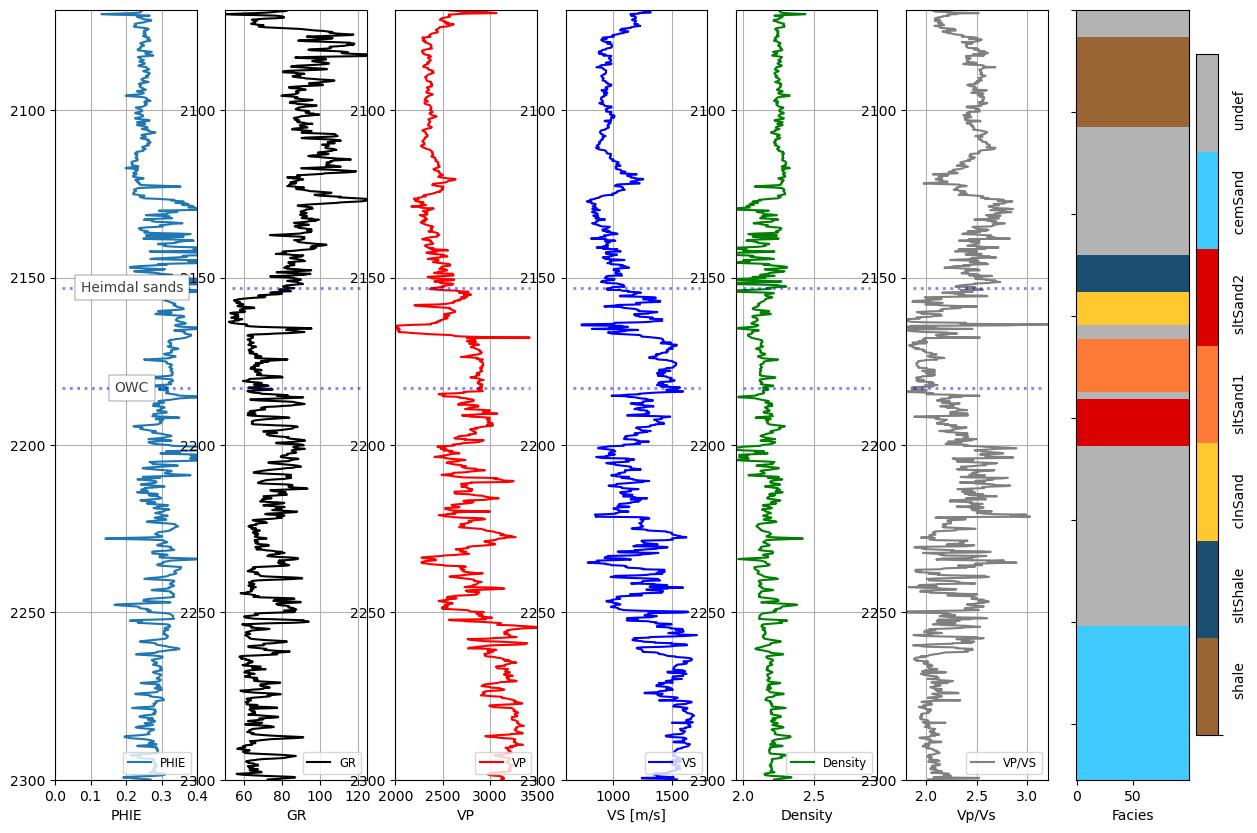

In [5]:
import matplotlib.colors as colors
ccc = ['#996633', '#1B4F72', '#FFC82E','#FF7A36', '#DB0000', '#40CBFF', '#B3B3B3']
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

ztop=2070; zbot=2300  #ztop=2140; zbot=2200
ll=well2[(well2.DEPTH>=ztop) & (well2.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['FCODES'].values,1), 100, 1)

f, ax = plt.subplots(nrows=1, ncols=7, figsize=(15, 10))

ax[0].plot(ll.PHIE,    ll.DEPTH,         label='PHIE')
ax[1].plot(ll.GR,      ll.DEPTH, '-k',   label='GR')
ax[2].plot(ll.VP*1000, ll.DEPTH, '-r',   label='VP')
ax[3].plot(ll.VS*1000, ll.DEPTH, 'blue', label='VS')
ax[4].plot(ll.RHOB,    ll.DEPTH, '-g',   label='Density')
ax[5].plot(ll.VPVS,    ll.DEPTH, '-', color='0.5', label='VP/VS')
im=ax[6].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=len(ax)-1)#4)

cbar=plt.colorbar(im, ax=ax[6], aspect=32)
cbar.set_label((9*' ').join(['shale', 'sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand', 'undef']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

for i in range(len(ax)-1):
    ax[i].set_ylim(ztop,zbot)
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].locator_params(axis='x', nbins=4)
    ax[i].legend(fontsize='small', loc='lower right')

ax[0].set_xlabel("PHIE"),          ax[0].set_xlim(0,0.4)
ax[1].set_xlabel("GR"),            ax[1].set_xlim(50, 125),
ax[2].set_xlabel("VP"),            ax[2].set_xlim(2000, 3500),
ax[4].set_xlabel("Density"),       ax[4].set_xlim(1.95, 2.95),
ax[3].set_xlabel("VS [m/s]"),      ax[3].set_xlim(600, 1800),
ax[5].set_xlabel("Vp/Vs"),         ax[5].set_xlim(1.8,3.2),
ax[6].set_xlabel('Facies'),  ax[6].set_yticklabels([])

tops = {
    "Heimdal sands": 2153,
    "OWC": 2183,
}

for i in range(len(ax)-1):
    for top in tops.values() :
        f.axes[i].axhline( y = float(top), color = 'b', lw = 2, 
                            ls = ':',  
                            alpha = 0.5, xmin = 0.05, xmax = 0.95 )
        
for top, depth in tops.items():
    if (ztop < depth < zbot):
        ax[1].text( x = max(ax[0].xaxis.get_data_interval())*1.0,
                  y = float(depth), s = top,
                             alpha=0.75, color='k',
                             fontsize = '10',
                             horizontalalignment = 'center',
                             verticalalignment = 'center',
                             bbox=dict(facecolor='white', alpha=1.0, lw = 0.25),
                             weight = 'light');

### Data histograms and resultant kernel estimates

The plot below shows the P-wave histograms and the calculated kernel estimates.

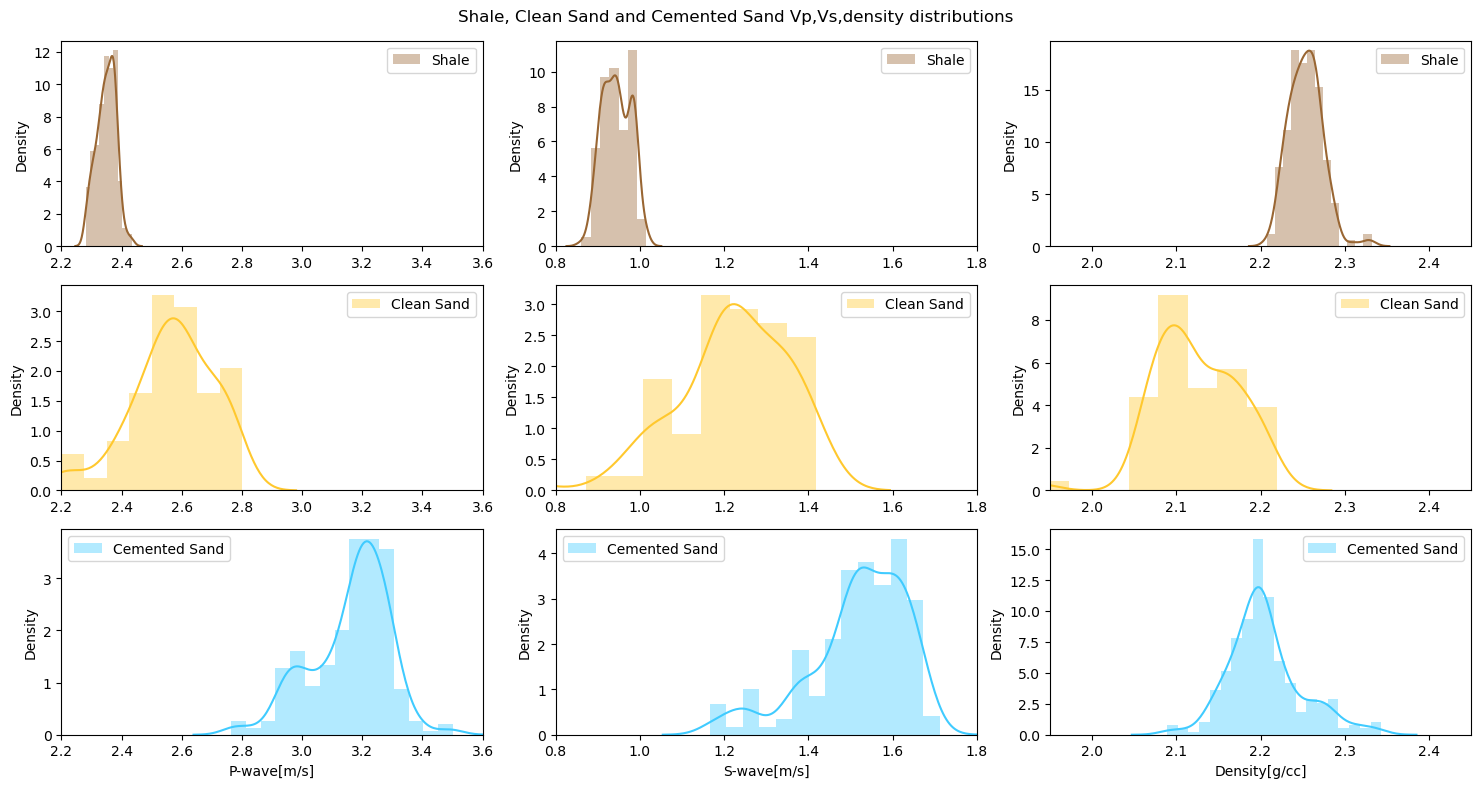

In [6]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3, figsize=(15,8))  # sharey=True, 
fig.suptitle('Shale, Clean Sand and Cemented Sand Vp,Vs,density distributions')

sns.distplot(ax=ax1, x=well2[well2.LABELS=='shale']['VP'], color=ccc[0], label="Shale")
sns.distplot(ax=ax2, x=well2[well2.LABELS=='shale']['VS'], color=ccc[0], label="Shale")
sns.distplot(ax=ax3, x=well2[well2.LABELS=='shale']['RHOB'], color=ccc[0], label="Shale")
sns.distplot(ax=ax4, x=well2[well2.LABELS=='clnSand']['VP'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax5, x=well2[well2.LABELS=='clnSand']['VS'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax6, x=well2[well2.LABELS=='clnSand']['RHOB'], color=ccc[2], label="Clean Sand")
sns.distplot(ax=ax7, x=well2[well2.LABELS=='cemSand']['VP'], color=ccc[5], label="Cemented Sand")
sns.distplot(ax=ax8, x=well2[well2.LABELS=='cemSand']['VS'], color=ccc[5], label="Cemented Sand")
sns.distplot(ax=ax9, x=well2[well2.LABELS=='cemSand']['RHOB'], color=ccc[5], label="Cemented Sand")

ax1.set_xlim(2.2,3.6), ax2.set_xlim(0.8,1.8), ax3.set_xlim(1.95,2.45)
ax4.set_xlim(2.2,3.6), ax5.set_xlim(0.8,1.8), ax6.set_xlim(1.95,2.45)
ax7.set_xlim(2.2,3.6), ax8.set_xlim(0.8,1.8), ax9.set_xlim(1.95,2.45)
ax7.set_xlabel('P-wave[m/s]'), ax8.set_xlabel('S-wave[m/s]'), ax9.set_xlabel('Density[g/cc]')

plt.tight_layout()
for ax in fig.get_axes():
    ax.legend()
    #ax.label_outer()

**(above)** The rows represent the P-wave, S-wave and density of a particular lithofacies.  The columns show the comparison of each lithofacies distribution for each log.  

If we were to assume these were normal distributions, then we could say the `shale` distribution had the lowest P-wave and S-wave `mean` and smallest `standard deviation` compared to `clnSand` and `cemSand`.  The `shale` density has the highest `mean` of the three.  `cemSand` has a higher P-wave, S-wave and density mean than `clnSand` but with similar `standard deviation`.

### Bivariate distribution of P-wave versus S-wave

The plot below demonstrates kernel density estimate of the bivaritate distributions P-wave and S-wave for `shale`, `clnSand` and `cemSand`. This plot shows the two-dimensional distributions of each of the three lithofacies. A random sample from each distribution maintains the bivariate correlation between the two parameters. 

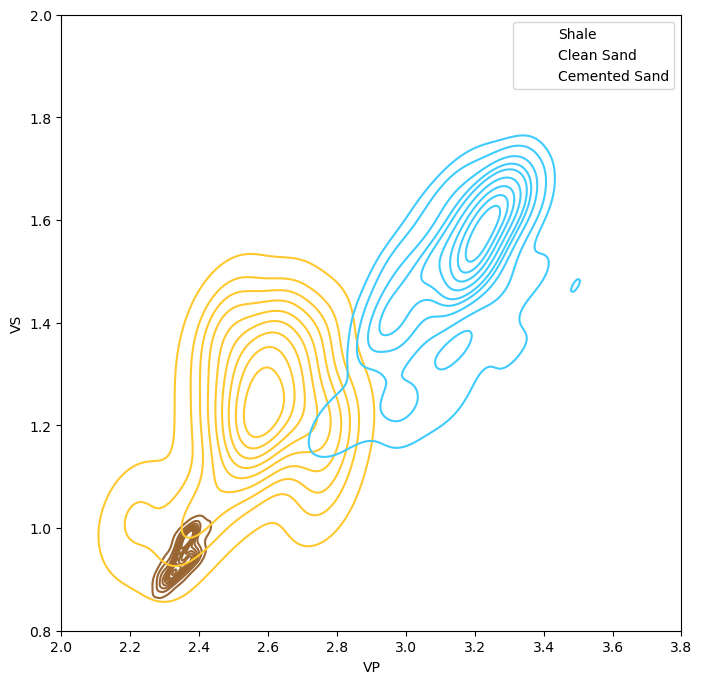

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.kdeplot(data=well2[well2.LABELS=='shale'], x='VP', y='VS', color=ccc[0], label="Shale")
sns.kdeplot(data=well2[well2.LABELS=='clnSand'], x='VP', y='VS', color=ccc[2], label="Clean Sand")
sns.kdeplot(data=well2[well2.LABELS=='cemSand'], x='VP', y='VS', color=ccc[5], label="Cemented Sand")

plt.xlim(2.,3.8); plt.ylim(0.8,2.)
plt.legend();

### Monte-Carlo simulation from non-parametric distributions

The function `kde_resample()` creates three-dimensional (3D) kernel density estimates (kde's) for each lithofacies/fluid scenario distribution.  Creating a 3D kde ensures that each time the distribution is sampled from, the correlation between the P-wave, S-wave and density is maintained. 

Once the kde has been calculated, the resampling method is called for a specified number of times (here 500).  The output of the function is then input to the `r0g()` function below.

In [8]:
# Function parameters
column = 'LABELS'
lith_list = ['shale', 'sltShale', 'clnSand', 'sltSand1', 'sltSand2', 'cemSand']
logs = ['VP', 'VS', 'RHOB']
num_samples = 500

kde = kde_resample(well2, column, lith_list, logs, num_samples=1000)

### Calculate R0-G from simulated distributions

The function `r0g()` samples Vp, Vs & rho from the simulated cap-rock kde, `shale`, and then the simulated reservoir (`sltShale`, `clnSand`, `sltSand1`, `sltSand2` and `cemSand`) kde.  The correlated parameters from each lithology are then input to the equation (see References) to obtain a reflection coefficient (R0) and gradient (G) which is then used to determine the reflection coefficient for a particular angle theta for theta between 0-40 degrees.

The median of all sampled data for each value of theta is calculated.

In [9]:
# [0][.]=='shale', [1][.]=='sltShale', [2][.]=='clnSand', [3][.]=='sltSand1'. [4][.]=='sltSand2', [5][.]=='cemSand'
# [.][0]=='VP', [.][1]=='VS', [.][2]=='RHOB'
# Assumes that cap rock is in position 0

# ------------------------------ r0g(vp0      , vs0      , rho0     , vp1      , vs1      , rho1)
r01_b, G1_b, Rtheta1_b, med1_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[1][0], kde[1][1], kde[1][2])
r02_b, G2_b, Rtheta2_b, med2_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[2][0], kde[2][1], kde[2][2])
r03_b, G3_b, Rtheta3_b, med3_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[3][0], kde[3][1], kde[3][2])
r04_b, G4_b, Rtheta4_b, med4_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[4][0], kde[4][1], kde[4][2])
r05_b, G5_b, Rtheta5_b, med5_b = r0g(kde[0][0], kde[0][1], kde[0][2], kde[5][0], kde[5][1], kde[5][2])

### Plot R0-G and Amplitude versus angle for each pair

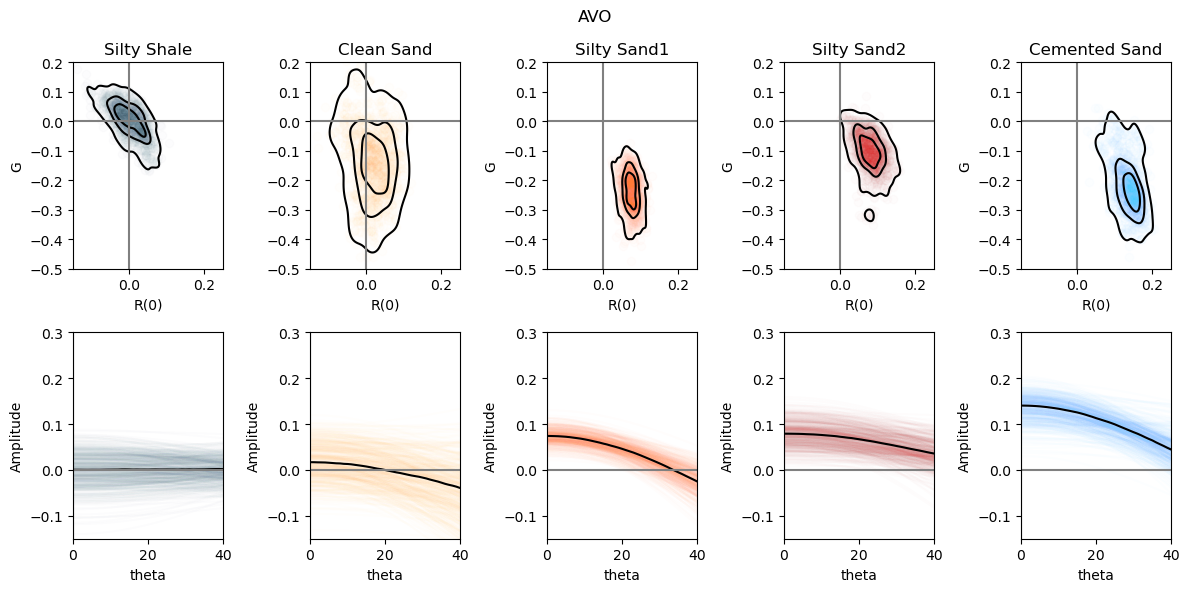

In [10]:
alpha1=0.01
alpha2=0.01

fig, ((ax1, ax2, ax3, ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2, 5, figsize=(12,6))
fig.suptitle('AVO')

ax1.set_title('Silty Shale')
ax1.scatter(r01_b, G1_b, alpha=alpha1, color=ccc[1])
sns.kdeplot(ax=ax1, x=r01_b, y=G1_b, color='k', linestyles="-", levels=4)
ax1.set_xlabel("R(0)"); ax1.set_ylabel("G")

ax2.set_title('Clean Sand')
ax2.scatter(r02_b, G2_b, alpha=alpha1, color=ccc[2])
sns.kdeplot(ax=ax2, x=r02_b, y=G2_b, color="k", linestyles="-", levels=4)
ax2.set_xlabel("R(0)"); ax3.set_ylabel("G")

ax3.set_title('Silty Sand1')
ax3.scatter(r03_b, G3_b, alpha=alpha1, color=ccc[3])
sns.kdeplot(ax=ax3, x=r03_b, y=G3_b, color="k", linestyles="-", levels=4)
ax3.set_xlabel("R(0)"); ax3.set_ylabel("G")

ax4.set_title('Silty Sand2')
ax4.scatter(r04_b, G4_b, alpha=alpha1, color=ccc[4])
sns.kdeplot(ax=ax4, x=r04_b, y=G4_b, color="k", linestyles="-", levels=4)
ax4.set_xlabel("R(0)"); ax4.set_ylabel("G")

ax5.set_title('Cemented Sand')
ax5.scatter(r05_b, G5_b, alpha=alpha1, color=ccc[5])
sns.kdeplot(ax=ax5, x=r05_b, y=G5_b, color="k", linestyles="-", levels=4)
ax5.set_xlabel("R(0)"); ax5.set_ylabel("G")

for i in range(num_samples):
    ax6.plot(Rtheta1_b[i][0], alpha=alpha2, color=ccc[1])
ax6.plot(med1_b, 'k')
ax6.set_xlabel("theta"); ax6.set_ylabel("Amplitude")

for i in range(num_samples):
    ax7.plot(Rtheta2_b[i][0], alpha=alpha2, color=ccc[2])
ax7.plot(med2_b, 'k')
ax7.set_xlabel("theta"); ax7.set_ylabel("Amplitude")

for i in range(num_samples):
    ax8.plot(Rtheta3_b[i][0], alpha=alpha2, color=ccc[3])
ax8.plot(med3_b, 'k')
ax8.set_xlabel("theta"); ax8.set_ylabel("Amplitude")

for i in range(num_samples):
    ax9.plot(Rtheta4_b[i][0], alpha=alpha2, color=ccc[4])
ax9.plot(med4_b, 'k')
ax9.set_xlabel("theta"); ax9.set_ylabel("Amplitude")

for i in range(num_samples):
    ax10.plot(Rtheta5_b[i][0], alpha=alpha2, color=ccc[5])
ax10.plot(med5_b, 'k')
ax10.set_xlabel("theta"); ax10.set_ylabel("Amplitude")

ax1.set_xlim(-0.15, 0.25); ax1.set_ylim(-0.5, 0.2);
ax2.set_xlim(-0.15, 0.25); ax2.set_ylim(-0.5, 0.2); 
ax3.set_xlim(-0.15, 0.25); ax3.set_ylim(-0.5, 0.2);
ax4.set_xlim(-0.15, 0.25); ax4.set_ylim(-0.5, 0.2);
ax5.set_xlim(-0.15, 0.25); ax5.set_ylim(-0.5, 0.2);

ax6.set_xlim(0,40); ax6.set_ylim(-0.15, 0.3);
ax7.set_xlim(0,40); ax7.set_ylim(-0.15, 0.3);
ax8.set_xlim(0,40); ax8.set_ylim(-0.15, 0.3);
ax9.set_xlim(0,40); ax9.set_ylim(-0.15, 0.3);
ax10.set_xlim(0,40); ax10.set_ylim(-0.15, 0.3);

for ax in fig.get_axes():
    #ax.legend()
    #ax.label_outer()
    ax.axvline(0, color='gray')
    ax.axhline(0, color='gray')
    
plt.tight_layout()
plt.savefig('Probabilistic_AVO_analysis.png');

**Top row**:  Bivariate distribution of the different seismic lithofacies in the R(0)-G plane, assuming silty shale is the cap rock.  The centre of each contour plot represents the most likely set of R(0) and G for each facies. The contours represent iso-probability values, decreasing away from the innermost contour.

**Bottom row**: AVO pdfs for each lithofacies pair. The cap-rock is represented by a silty shale.  The superimposed black lines are the deterministic AVO responses calculated from the median values of the pdfs.  The equation $R(\theta) \approx R(0) + G\sin^2\theta$ is used to calculate these pdfs.

## References

* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).

### Equations
$R(\theta_1)\approx \dfrac{1}{2}\big(1-4p^2V_S^2\big)\dfrac{\Delta \rho}{\rho}+\dfrac{1}{2\cos^2\theta}\dfrac{\Delta V_P}{V_P}-4p^2V_S^2\dfrac{\Delta V_S}{V_S}$